In [532]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 dispenser1 => {'learning_rate': 0.004990958315418308, 'depth': 6, 'l2_leaf_reg': 10} => 0.63

 dispenser 2 => {'learning_rate': 0.0033973240926824105, 'depth': 8, 'l2_leaf_reg': 6} -> 0.58 0.24

> ### 라이브러리 호출

In [533]:
import os
from pprint import pprint

# 데이터 전처리 및 모델링
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

#불필요한 경고 제거
import warnings
warnings.filterwarnings("ignore")

In [534]:
def read_excel_file(file_path: str, header: int = None) -> pd.DataFrame:
    csv_file = file_path.replace(".xlsx", ".csv")

    if not os.path.exists(csv_file):
        print("Converting excel to csv...")
        if header:
            df = pd.read_excel(file_path, header=header)
        else:
            df = pd.read_excel(file_path)

        df.to_csv(csv_file, index=False)
        print(f"  {file_path} -> {csv_file}")
        return df
    else:
        print(f"  Reading {csv_file}")
        return pd.read_csv(csv_file, low_memory=False)

In [535]:
# Columns 리스트 생략 없이 전부 출력하기
pd.set_option('display.max_seq_items', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

In [536]:
ROOT_DIR = "/content/drive/MyDrive/LG AImers/data set/"
RANDOM_STATE = 110

# Load_train_data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))

In [537]:
# Load_test_data
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
submission_df = pd.read_csv(os.path.join(ROOT_DIR, "submission.csv"))

In [538]:
# ROOT_DIR = "/content/drive/MyDrive/LG AImers/data set/Final Data/"
# # 수정 data
# dispenser1_df_train = pd.read_csv(os.path.join(ROOT_DIR, "dispenser1_df_train_0825.csv"),index_col=0)
# dispenser2_df_train = pd.read_csv(os.path.join(ROOT_DIR, "dispenser2_df_train_0825.csv"),index_col=0)
# dispenser1_df_test = pd.read_csv(os.path.join(ROOT_DIR, "dispenser1_df_test_0825.csv"),index_col=0)
# dispenser2_df_test = pd.read_csv(os.path.join(ROOT_DIR, "dispenser2_df_test_0825.csv"),index_col=0)

## 데이터 전처리

### STEP 1. Column의 값이 모두 Nan이거나 값이 모두 같은 feature 제거

In [539]:
def remove_constant_columns(df: pd.DataFrame) -> pd.DataFrame:
  # 값이 모두 NaN인 열 제거
  df = df.dropna(axis=1, how='all')

  # NaN을 포함하여 unique한 값이 2개 이상인 열만 선택
  df = df.loc[:, df.apply(lambda x: x.nunique(dropna=False)) > 1]

  return df

### STEP 2. Solve Column Shift Problem

- HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result 값이 OK / NaN인 값은 모두 HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result 칼럼부터 WorkMode Collect Result까지 data 값이 하나씩 밀려있다.

> 1. split_dataframe_by_column_suffix => dam / fill1 / fill2 / autoclave 분리
2. shift_columns_forward_conditionally_dam => dam 관련 data 오류 해결
3. shift_columns_forward_conditionally_fill1  => fill1 관련 data 오류 해결
4. shift_columns_forward_conditionally_fill2 => fill2 관련 data 오류 해결

> **결측값 처리**
- 전체 40506개의 data 중 24059개의 결측값이 존재하기에 drop
- **HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value & GMES_ORIGIN_INSP_JUDGE_CODE 관련 컬럼 DROP**
- **WorkMode Collect Result_Dam, WorkMode Collect Result_Fill1, WorkMode Collect Result_Fill2 칼럼 DROP**

In [540]:
# HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value 관련 컬럼 DROP
# GMES_ORIGIN_INSP_JUDGE_CODE 관련 컬럼 DROP

def drop_columns_with_string(df, substring):
  df_filtered = df.drop(columns=[col for col in df.columns if substring in col])
  return df_filtered

> 기존 dataframe에서 target column 추출

In [541]:
train_data_target_df = train_data["target"]

In [542]:
def split_dataframe_by_column_suffix(df):
    """
    주어진 데이터프레임에서 컬럼명이 'Dam', 'Fill1', 'Fill2', 'AutoClave'로 끝나는 열들로
    구성된 4개의 데이터프레임으로 나누어 반환합니다.

    Parameters:
    - df: pd.DataFrame - 원본 데이터프레임

    Returns:
    - pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame - 나눠진 4개의 데이터프레임
    """
    # 'Dam'으로 끝나는 칼럼
    dam_columns = [col for col in df.columns if col.endswith('Dam')]
    df_dam = df[dam_columns]

    # 'Fill1'로 끝나는 칼럼
    fill1_columns = [col for col in df.columns if col.endswith('Fill1')]
    df_fill1 = df[fill1_columns]

    # 'Fill2'로 끝나는 칼럼
    fill2_columns = [col for col in df.columns if col.endswith('Fill2')]
    df_fill2 = df[fill2_columns]

    # 'AutoClave'로 끝나는 칼럼
    autoclave_columns = [col for col in df.columns if col.endswith('AutoClave')]
    df_autoclave = df[autoclave_columns]

    return df_dam, df_fill1, df_fill2, df_autoclave

In [543]:
import pandas as pd

def shift_columns_forward_conditionally_dam(df):
    # 복사본을 생성하여 원본을 유지합니다.
    df_shifted = df.copy()

    # 조건에 해당하는 행들을 필터링
    condition = df["HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam"].isin(["OK"]) | df["HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam"].isna()

    # 컬럼 이름 목록
    columns_to_shift = [
        "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam",
        "HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam",
        "HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam",
        "HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam",
        "HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam",
        "HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam",
        "HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam",
        "HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam",
        "HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam",
        "HEAD Standby Position X Collect Result_Dam",
        "HEAD Standby Position Y Collect Result_Dam",
        "HEAD Standby Position Z Collect Result_Dam",
        "Head Clean Position X Collect Result_Dam",
        "Head Clean Position Y Collect Result_Dam",
        "Head Clean Position Z Collect Result_Dam",
        "Head Purge Position X Collect Result_Dam",
        "Head Purge Position Y Collect Result_Dam",
        "Head Purge Position Z Collect Result_Dam",
        "Head Zero Position X Collect Result_Dam",
        "Head Zero Position Y Collect Result_Dam",
        "Head Zero Position Z Collect Result_Dam",
        "Machine Tact time Collect Result_Dam",
        "PalletID Collect Result_Dam",
        "Production Qty Collect Result_Dam",
        "Receip No Collect Result_Dam",
        "Stage1 Circle1 Distance Speed Collect Result_Dam",
        "Stage1 Circle2 Distance Speed Collect Result_Dam",
        "Stage1 Circle3 Distance Speed Collect Result_Dam",
        "Stage1 Circle4 Distance Speed Collect Result_Dam",
        "Stage1 Line1 Distance Speed Collect Result_Dam",
        "Stage1 Line2 Distance Speed Collect Result_Dam",
        "Stage1 Line3 Distance Speed Collect Result_Dam",
        "Stage1 Line4 Distance Speed Collect Result_Dam",
        "Stage2 Circle1 Distance Speed Collect Result_Dam",
        "Stage2 Circle2 Distance Speed Collect Result_Dam",
        "Stage2 Circle3 Distance Speed Collect Result_Dam",
        "Stage2 Circle4 Distance Speed Collect Result_Dam",
        "Stage2 Line1 Distance Speed Collect Result_Dam",
        "Stage2 Line2 Distance Speed Collect Result_Dam",
        "Stage2 Line3 Distance Speed Collect Result_Dam",
        "Stage2 Line4 Distance Speed Collect Result_Dam",
        "Stage3 Circle1 Distance Speed Collect Result_Dam",
        "Stage3 Circle2 Distance Speed Collect Result_Dam",
        "Stage3 Circle3 Distance Speed Collect Result_Dam",
        "Stage3 Circle4 Distance Speed Collect Result_Dam",
        "Stage3 Line1 Distance Speed Collect Result_Dam",
        "Stage3 Line2 Distance Speed Collect Result_Dam",
        "Stage3 Line3 Distance Speed Collect Result_Dam",
        "Stage3 Line4 Distance Speed Collect Result_Dam",
        "THICKNESS 1 Collect Result_Dam",
        "THICKNESS 2 Collect Result_Dam",
        "THICKNESS 3 Collect Result_Dam",
        "WorkMode Collect Result_Dam"
    ]


    # 조건을 만족하는 행들에 대해서만 값을 이동
    for i in range(len(columns_to_shift) - 1):
        df_shifted.loc[condition, columns_to_shift[i]] = df_shifted.loc[condition, columns_to_shift[i + 1]]

    # 마지막 컬럼을 NaN으로 설정
    df_shifted.loc[condition, columns_to_shift[-1]] = pd.NA

    return df_shifted


In [544]:
def shift_columns_forward_conditionally_fill1(df):
    # 복사본을 생성하여 원본을 유지합니다.
    df_shifted = df.copy()

    # 조건에 해당하는 행들을 필터링
    condition = df["HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1"].isin(["OK"]) | df["HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1"].isna()

    # 컬럼 이름 목록
    columns_to_shift = [
        "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1",
        "HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1",
        "HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1",
        "HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1",
        "HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1",
        "HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1",
        "HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1",
        "HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1",
        "HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1",
        "HEAD Standby Position X Collect Result_Fill1",
        "HEAD Standby Position Y Collect Result_Fill1",
        "HEAD Standby Position Z Collect Result_Fill1",
        "Head Clean Position X Collect Result_Fill1",
        "Head Clean Position Y Collect Result_Fill1",
        "Head Clean Position Z Collect Result_Fill1",
        "Head Purge Position X Collect Result_Fill1",
        "Head Purge Position Y Collect Result_Fill1",
        "Head Purge Position Z Collect Result_Fill1",
        "Machine Tact time Collect Result_Fill1",
        "PalletID Collect Result_Fill1",
        "Production Qty Collect Result_Fill1",
        "Receip No Collect Result_Fill1",
        "WorkMode Collect Result_Fill1"
    ]

    # 조건을 만족하는 행들에 대해서만 값을 이동
    for i in range(len(columns_to_shift) - 1):
        df_shifted.loc[condition, columns_to_shift[i]] = df_shifted.loc[condition, columns_to_shift[i + 1]]

    # 마지막 컬럼을 pd.NA로 설정
    df_shifted.loc[condition, columns_to_shift[-1]] = pd.NA

    return df_shifted


In [545]:
def shift_columns_forward_conditionally_fill2(df):
    # 복사본을 생성하여 원본을 유지합니다.
    df_shifted = df.copy()

    # 조건에 해당하는 행들을 필터링
    condition = df["HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2"].isin(["OK"]) | df["HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2"].isna()

    # 새로운 컬럼 이름 목록
    columns_to_shift = [
        "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2",
        "HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2",
        "HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2",
        "HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2",
        "HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2",
        "HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2",
        "HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2",
        "HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2",
        "HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2",
        "HEAD Standby Position X Collect Result_Fill2",
        "HEAD Standby Position Y Collect Result_Fill2",
        "HEAD Standby Position Z Collect Result_Fill2",
        "Head Clean Position X Collect Result_Fill2",
        "Head Clean Position Y Collect Result_Fill2",
        "Head Clean Position Z Collect Result_Fill2",
        "Head Purge Position X Collect Result_Fill2",
        "Head Purge Position Y Collect Result_Fill2",
        "Head Purge Position Z Collect Result_Fill2",
        "Machine Tact time Collect Result_Fill2",
        "PalletID Collect Result_Fill2",
        "Production Qty Collect Result_Fill2",
        "Receip No Collect Result_Fill2",
        "WorkMode Collect Result_Fill2"
    ]

    # 조건을 만족하는 행들에 대해서만 값을 이동
    for i in range(len(columns_to_shift) - 1):
        df_shifted.loc[condition, columns_to_shift[i]] = df_shifted.loc[condition, columns_to_shift[i + 1]]

    # 마지막 컬럼을 pd.NA로 설정
    df_shifted.loc[condition, columns_to_shift[-1]] = pd.NA

    return df_shifted


### STEP 3. Data Frame 병합



#### STEP 3-1. Data Frame 병합

In [546]:
def concatenate_dataframes(*dfs):
  # 데이터프레임의 개수가 4개 또는 5개인지 확인
  if len(dfs) not in [4, 5]:
    raise ValueError("입력 데이터프레임의 개수는 target을 포함한 5개이거나 target을 제외한 4개여야 합니다.")

  # 모든 데이터프레임이 동일한 행의 개수를 가지는지 확인
  row_counts = [df.shape[0] for df in dfs]
  if len(set(row_counts)) != 1:
    raise ValueError("모든 데이터프레임의 행의 개수가 동일해야 합니다.")

  # 데이터프레임들을 옆으로 붙이기
  merged_data_frame_correct = pd.concat(dfs, axis=1)

    # 'WorkMode'가 컬럼명에 포함된 모든 컬럼을 드롭(drop)
  columns_to_drop = [col for col in merged_data_frame_correct.columns if 'WorkMode' in col]
  merged_data_frame_drop_workmode_col = merged_data_frame_correct.drop(columns = columns_to_drop)

  return merged_data_frame_drop_workmode_col

#### STEP 3-2. **'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result' 관련 컬럼의 데이터 타입 숫자형으로 변경**
- Column Shift 문제를 해결한 후 HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result 관련 컬럼들의 data type이 모두 category형으로 남아있기에 float 타입으로 변경해준다.

In [547]:
def convert_columns_to_float(df, keyword):
    """
    Parameters:
    - df (pd.DataFrame): 변환할 데이터 프레임
    - keyword (str): 칼럼명에 포함된 키워드

    Returns:
    - pd.DataFrame: 변환된 데이터 프레임
    """
    # 키워드를 포함하는 칼럼명을 찾기
    columns_to_convert = [col for col in df.columns if keyword in col]

    # 해당 칼럼들을 실수형으로 변환
    df[columns_to_convert] = df[columns_to_convert].astype(float)

    return df

### STEP 4. 무조건 AbNormal인 조건을 만족하는 row의 index 저장

#### STEP 4-1. 제조 공정 중 Qty 변화 있으면 AbNormal

In [548]:
def filter_different_rows_Qty(df):
    # 제조 공정 중 Qty 칼럼값에 변화가 있는 row
    condition = (df['Production Qty Collect Result_Dam'] != df['Production Qty Collect Result_Fill1']) | \
                (df['Production Qty Collect Result_Dam'] != df['Production Qty Collect Result_Fill2']) | \
                (df['Production Qty Collect Result_Fill1'] != df['Production Qty Collect Result_Fill2'])

    # 조건을 만족하는 행들로 구성된 데이터프레임
    filtered_df = df[condition]

    # 입력 데이터프레임과 필터링된 데이터프레임 반환
    return filtered_df, df

#### STEP 4-2. 제조 공정 중 Pallet ID 변화 있으면 AbNormal

In [549]:
def filter_different_rows_PalletID(df):
    # 제조 공정 중 Pallet ID 칼럼값에 변화가 있는 row
    condition = (df['PalletID Collect Result_Dam'] != df['PalletID Collect Result_Fill1']) | \
                (df['PalletID Collect Result_Dam'] != df['PalletID Collect Result_Fill2']) | \
                (df['PalletID Collect Result_Fill1'] != df['PalletID Collect Result_Fill2'])

    # 조건을 만족하는 행들로 구성된 데이터프레임
    filtered_df = df[condition]

    # 입력 데이터프레임과 필터링된 데이터프레임 반환
    return filtered_df, df

#### STEP 4-3. 제조 공정 중 Receip No 변화 있으면 AbNormal

In [550]:
def filter_different_rows_Receip(df):
    # 제조 공정 중 Receip No 칼럼값에 변화가 있는 row
    condition = (df['Receip No Collect Result_Dam'] != df['Receip No Collect Result_Fill1']) | \
                (df['Receip No Collect Result_Dam'] != df['Receip No Collect Result_Fill2']) | \
                (df['Receip No Collect Result_Fill1'] != df['Receip No Collect Result_Fill2'])

    # 조건을 만족하는 행들로 구성된 데이터프레임
    filtered_df = df[condition]

    # 입력 데이터프레임과 필터링된 데이터프레임 반환
    return filtered_df, df

#### STEP 4-4. 제조 공정 중 Equipment 변화 있으면 AbNormal

In [551]:
def filter_different_rows_Equipment(df):
    # 각 칼럼의 값의 마지막 글자 추출
    last_char_dam = df['Equipment_Dam'].astype(str).str[-1]
    last_char_fill1 = df['Equipment_Fill1'].astype(str).str[-1]
    last_char_fill2 = df['Equipment_Fill2'].astype(str).str[-1]

    # 제조 공정 중 Equipment 칼럼값에 변화가 있는 row
    condition = (last_char_dam != last_char_fill1) | (last_char_dam != last_char_fill2) | (last_char_fill1 != last_char_fill2)

    # 조건을 만족하는 행들로 구성된 데이터프레임
    filtered_df = df[condition]

    # 입력 데이터프레임과 필터링된 데이터프레임 반환
    return filtered_df, df

### STEP 5. 무조건 AbNormal인 값들의 index 저장하기

> 무조건 AbNormal인 row의 index들을 저장한 후, 학습 과정에서는 제외시킨 후 이후에 최종 과정에서 바꿔준다.

In [552]:
# 무조건 Error가 발생하는 데이터들의 row index를 반환하는 함수
def get_unique_row_indices_with_AbNormal(*dfs):
    """
    dfs (tuple): 데이터 프레임들의 튜플
    ex) AbNormal_row_index = get_unique_row_indices(data_with_dispensesr_error_df, data_with_Qty_error_df)
    """
    # 중복을 제거하기 위해 set 사용
    unique_indices = set()

    # 각 데이터 프레임에 대해 인덱스를 추출하여 set에 추가
    for df in dfs:
      unique_indices.update(df.index)

    # 중복 없는 인덱스를 리스트로 변환하여 반환
    return list(unique_indices)

> 무조건 AbNormal인 row의 인덱스들의 데이터 프레임을 drop

In [553]:
def remove_rows_by_indices(df, indices_to_remove):
    return df.drop(index=indices_to_remove)

### STEP 6. Dispenser의 종류에 따라 Data Frame Split

In [554]:
# Equipment_Dam를 각 제품들의 original 설정값이라는 가정하에, dam에서의 dispenser에 따라 데이터프레임 분할
def Seperate_data_by_Dam_dispenser(df):
  # Equipment_Dam 칼럼의 값이 "Dam dispenser #1"인 경우
  df_dispenser_1 = df[df['Equipment_Dam'] == 'Dam dispenser #1']

  # Equipment_Dam 칼럼의 값이 "Dam dispenser #2"인 경우
  df_dispenser_2 = df[df['Equipment_Dam'] == 'Dam dispenser #2']

  # 각각의 분할된 데이터프레임 반환
  return df_dispenser_1, df_dispenser_2

> **Dispenser에 따라 나눈 후, Equipment 관련 컬럼 DROP**

```python
dispenser1_df_train = drop_columns_with_string(dispenser1_df_train, "Equipment")
dispenser2_df_train = drop_columns_with_string(dispenser2_df_train, "Equipment")
```



> **파생변수1 : Chamber, Pressure 관련 파생변수**
- Chamber, Pressure 관련 파생변수 생성 및 관련 column drop

In [555]:
def Change_chamber_pressure_column(df):
    # 1. 새로운 칼럼 생성
    df['1st_total_Pressure'] = df['1st Pressure Collect Result_AutoClave'] * df['1st Pressure 1st Pressure Unit Time_AutoClave']
    df['2nd_total_Pressure'] = df['2nd Pressure Collect Result_AutoClave'] * df['2nd Pressure Unit Time_AutoClave']
    df['3rd_total_Pressure'] = df['3rd Pressure Collect Result_AutoClave'] * df['3rd Pressure Unit Time_AutoClave']

    # 3. 작업 완료된 데이터프레임 반환
    return df

#### **파생변수3 : Workorder + SUFFIX 관련 파생변수 제작**
- AbNormal 비율이 높은 WorkOrder, Suffix 조합 구별

In [556]:
# AbNormal 비율이 높은 WorkOrder, Suffix 조합 리스트 제작
def identify_defective_groups_Workorder_Suffix(df):
    """
    데이터프레임을 그룹화하여 각 그룹의 'target' 칼럼에서 'AbNormal' 비율을 계산하고,
    비율이 0.2를 넘는 'Model.Suffix_Dam'-'Workorder_Dam'이 기입된 이중 리스트를 반환합니다.
    """
    # 결과를 저장할 리스트
    Defective_Suffix_Workorder_list = []

    # 그룹화
    grouped = df.groupby(['Model.Suffix_Dam', 'Workorder_Dam'])

    # 각 그룹에서 'AbNormal' 비율 계산
    abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())

    # 비율이 0.2를 넘는 그룹 필터링
    high_abnormal_ratio_groups = abnormal_ratio[abnormal_ratio > 0.2]

    # 비율이 0.2를 넘는 그룹의 'Model.Suffix_Dam'과 'Workorder_Dam' 값을 리스트로 변환
    for (suffix, workorder) in high_abnormal_ratio_groups.index:
        Defective_Suffix_Workorder_list.append([suffix, workorder])

    return Defective_Suffix_Workorder_list

In [557]:
def make_PROBA_Workorder_Suffix_Column(df, defective_suffix_workorder_list):
    """
    주어진 데이터프레임과 이중 리스트를 바탕으로 PROBA_WORKORDER_SUFFIX 칼럼을 업데이트합니다.
    """
    # PROBA_WORKORDER_SUFFIX 칼럼을 0으로 초기화
    df['PROBA_WORKORDER_SUFFIX'] = 0

    # 이중 리스트의 각 원소를 순회
    for suffix, workorder in defective_suffix_workorder_list:
        # 'Model.Suffix_Dam'과 'Workorder_Dam'이 주어진 값과 일치하는 행의 'PROBA_WORKORDER_SUFFIX' 값을 1로 변경
        df.loc[(df['Model.Suffix_Dam'] == suffix) & (df['Workorder_Dam'] == workorder), 'PROBA_WORKORDER_SUFFIX'] = 1

    # 'PROBA_WORKORDER_SUFFIX' 칼럼의 값을 LOW_WS와 HIGH_WS로 변경
    df['PROBA_WORKORDER_SUFFIX'] = df['PROBA_WORKORDER_SUFFIX'].map({0: 'LOW_WS', 1: 'HIGH_WS'})

    # 'PROBA_WORKORDER_SUFFIX' 칼럼을 category 타입으로 변경
    df['PROBA_WORKORDER_SUFFIX'] = df['PROBA_WORKORDER_SUFFIX'].astype('category')

    return df

### STEP 7. Dispenser 구별 후 행이 같은 경우에 중복되는 값을 가지는 Columns DROP

In [558]:
def find_identical_value_columns(df):
  # 결과를 저장할 딕셔너리 생성
  identical_columns = {}

  # 데이터 프레임의 모든 칼럼을 순회
  for i, col1 in enumerate(df.columns):
    for col2 in df.columns[i+1:]:
      # 두 칼럼의 값이 동일한지 확인
      if df[col1].equals(df[col2]):
        # 동일한 값을 가지는 칼럼을 리스트에 추가
        if col1 not in identical_columns:
          identical_columns[col1] = []
          identical_columns[col1].append(col2)

  return identical_columns

In [559]:
from collections import defaultdict

def build_graph(identical_columns):
    graph = defaultdict(set)

    for key, values in identical_columns.items():
        for value in values:
            graph[key].add(value)
            graph[value].add(key)

    return graph

def find_connected_components(graph):
    visited = set()
    components = []

    def dfs(node, component):
        stack = [node]
        while stack:
            v = stack.pop()
            if v not in visited:
                visited.add(v)
                component.append(v)
                stack.extend(graph[v] - visited)

    for node in graph:
        if node not in visited:
            component = []
            dfs(node, component)
            components.append(component)

    return components

In [560]:
def drop_duplicate_columns(df, components):
  # Collect columns to drop
  columns_to_drop = set()
  for component in components:
    if len(component) > 1:
      # Skip the first column, mark others for dropping
      columns_to_drop.update(component[1:])

  # Drop columns from the DataFrame
  final_df = df.drop(columns=columns_to_drop, errors='ignore')

  return final_df

### STEP 8. Dispenser 구별 후 UNIQUE한 값을 1개만 가지는 Columns DROP

In [561]:
# 주어진 데이터프레임에서 고유한 값이 1개인 칼럼을 제거하고 새로운 데이터프레임을 반환
def drop_single_unique_columns(df):
  # 각 칼럼의 고유 값 개수를 확인
  unique_counts = df.nunique()

  # 고유 값이 1개인 칼럼 이름 찾기
  single_unique_cols = unique_counts[unique_counts == 1].index

  # 해당 칼럼을 제거한 새로운 데이터프레임 생성
  df_dropped = df.drop(columns=single_unique_cols)
  return df_dropped

> **Model.Suffix, Workorder 관련 칼럼 DROP**



```python
dispenser1_df_train = drop_columns_with_string(dispenser1_df_train, "Model.Suffix")
dispenser1_df_train = drop_columns_with_string(dispenser1_df_train, "Workorder")
dispenser2_df_train = drop_columns_with_string(dispenser2_df_train, "Model.Suffix")
dispenser2_df_train = drop_columns_with_string(dispenser2_df_train, "Workorder")
```



### STEP 9. Target Column 및 Object 데이터 타입 Column들 데이터 타입 변경
- Normal => 0
- AbNormal => 1
- target 칼럼의 데이터 타입을 정수형으로 변환
- 피쳐의 데이터 타입이 object형인 칼럼 => categorical로 변환

In [562]:
# Object data type => category형으로 변환
def convert_to_category(df):
  """
  주어진 데이터 프레임에서 target 칼럼을 제외한 수치형이 아닌 모든 칼럼에 대해 범주형으로 변환
  Returns : pandas.DataFrame: 범주형으로 변환된 데이터 프레임
  """
  # 'target' 칼럼이 있는 경우, 이를 제외한 나머지 칼럼들을 처리
  if 'target' in df.columns:
    columns_to_convert = df.select_dtypes(exclude=['number']).columns.difference(['target'])
  else:
    columns_to_convert = df.select_dtypes(exclude=['number']).columns

  # 수치형이 아닌 칼럼들을 범주형으로 변환
  df[columns_to_convert] = df[columns_to_convert].astype('category')

  return df

In [563]:
# target값 0과 1로 변환
def change_target_column_data_type(df):
  df["target"] = df["target"].map({"Normal": 0, "AbNormal": 1})
  df["target"] = df["target"].astype(int)
  return df

## Train Data

In [564]:
# <<<<< STEP1 >>>>>
# Column의 값이 모두 Nan이거나 값이 모두 같은 feature 제거
train_data = remove_constant_columns(train_data)

# <<<<< STEP2 >>>>>
# HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value 관련 컬럼 DROP
# GMES_ORIGIN_INSP_JUDGE_CODE 관련 컬럼 DROP
train_data = drop_columns_with_string(train_data, "HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value")
train_data = drop_columns_with_string(train_data, "GMES_ORIGIN_INSP_JUDGE_CODE")

# 기존 dataframe에서 target column 추출
train_data_target_df = train_data["target"]
train_data_to_match_column_with_test_data = train_data

#  Solve Column Shift Problem
df_dam, df_fill1, df_fill2, df_autoclave = split_dataframe_by_column_suffix(train_data)
df_dam_correct = shift_columns_forward_conditionally_dam(df_dam)
df_fill1_correct = shift_columns_forward_conditionally_fill1(df_fill1)
df_fill2_correct = shift_columns_forward_conditionally_fill2(df_fill2)

# <<<<< STEP3 >>>>>
# dataframe 병합
train_data_correct = concatenate_dataframes(df_dam_correct, df_fill1_correct, df_fill2_correct, df_autoclave, train_data_target_df)

# 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result' 관련 컬럼의 데이터 타입 숫자형으로 변경
train_data_correct = convert_columns_to_float(train_data_correct, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result')

# <<<<< STEP4 >>>>> : 무조건 AbNormal인 조건을 만족하는 row의 index 저장
# 제조 공정 중 Qty 변화가 있는 데이터 프레임
data_with_Qty_error_df_train, train_data_correct = filter_different_rows_Qty(train_data_correct)

# 제조 공정 중 PalletID 변화 있는 데이터 프레임
data_with_PalletID_error_df_train, train_data_correct = filter_different_rows_PalletID(train_data_correct)

# 제조 공정 중 Receip No 변화 있는 데이터 프레임
data_with_Receip_error_df_train, train_data_correct = filter_different_rows_Receip(train_data_correct)

# 제조 공정 중 Equipment 변화 있는 데이터 프레임
data_with_Equipment_error_df_train, train_data_correct = filter_different_rows_Equipment(train_data_correct)

# <<<<< STEP5 >>>>>
# 무조건 AbNormal인 값들의 index 저장하기
AbNormal_row_index_list_train = get_unique_row_indices_with_AbNormal(data_with_Qty_error_df_train, data_with_PalletID_error_df_train, data_with_Receip_error_df_train, data_with_Equipment_error_df_train)

# 해당 인덱스의 dataframe 지우기
train_data_correct = remove_rows_by_indices(train_data_correct, AbNormal_row_index_list_train)

# <<<<< STEP6 >>>>>
# Dispenser의 종류에 따라 Data Frame Split
dispenser1_df_train , dispenser2_df_train = Seperate_data_by_Dam_dispenser(train_data_correct)

# Equipment 관련 컬럼 DROP
dispenser1_df_train = drop_columns_with_string(dispenser1_df_train, "Equipment")
dispenser2_df_train = drop_columns_with_string(dispenser2_df_train, "Equipment")

# Workorder + SUFFIX 관련 파생변수 제작
# AbNormal 비율이 높은 WorkOrder, Suffix 조합 리스트
Defective_Suffix_Workorder_list_dispenesr1 = identify_defective_groups_Workorder_Suffix(dispenser1_df_train)
Defective_Suffix_Workorder_list_dispenesr2 = identify_defective_groups_Workorder_Suffix(dispenser2_df_train)

dispenser1_df_train = make_PROBA_Workorder_Suffix_Column(dispenser1_df_train, Defective_Suffix_Workorder_list_dispenesr1)
dispenser2_df_train = make_PROBA_Workorder_Suffix_Column(dispenser2_df_train, Defective_Suffix_Workorder_list_dispenesr2)

# <<<<< STEP7 >>>>>
# 행이 같은 경우에 중복되는 값을 가지는 Columns DROP
identical_columns_in_df1_train = find_identical_value_columns(dispenser1_df_train)
identical_columns_in_df2_train = find_identical_value_columns(dispenser2_df_train)
graph1_train = build_graph(identical_columns_in_df1_train)
graph2_train = build_graph(identical_columns_in_df2_train)
components1_train = find_connected_components(graph1_train)
components2_train = find_connected_components(graph2_train)
dispenser1_df_train = drop_duplicate_columns(dispenser1_df_train, components1_train)
dispenser2_df_train = drop_duplicate_columns(dispenser2_df_train, components2_train)

# <<<<< STEP8 >>>>>
# UNIQUE한 값을 가지는 Columns DROP
dispenser1_df_train = drop_single_unique_columns(dispenser1_df_train)
dispenser2_df_train = drop_single_unique_columns(dispenser2_df_train)

# Model.Suffix, Workorder 관련 칼럼 DROP
dispenser1_df_train = drop_columns_with_string(dispenser1_df_train, "Model.Suffix")
dispenser1_df_train = drop_columns_with_string(dispenser1_df_train, "Workorder")
dispenser2_df_train = drop_columns_with_string(dispenser2_df_train, "Model.Suffix")
dispenser2_df_train = drop_columns_with_string(dispenser2_df_train, "Workorder")

# <<<<< STEP9 >>>>>
# Object data type => category형으로 변환
dispenser1_df_train = convert_to_category(dispenser1_df_train)
dispenser2_df_train = convert_to_category(dispenser2_df_train)

# target column -> 0(Normal)과 1(AbNormal)로 변경
dispenser1_df_train = change_target_column_data_type(dispenser1_df_train)
dispenser2_df_train = change_target_column_data_type(dispenser2_df_train)

## Test Data

In [565]:
def filter_columns_for_test_dataset_first(test_data_df, train_data_df):
  dataframe_for_Columns = remove_constant_columns(train_data)
  dataframe_for_Columns = drop_columns_with_string(dataframe_for_Columns, "HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value")
  dataframe_for_Columns = drop_columns_with_string(dataframe_for_Columns, "GMES_ORIGIN_INSP_JUDGE_CODE")

  # train dataset의 컬럼들
  first_remain_column_list = dataframe_for_Columns.columns

  # 입력 데이터프레임의 칼럼 목록
  df_columns = test_data_df.columns

  # 데이터프레임의 칼럼 중 train_data에 있는 칼럼만 필터링
  columns_to_keep = [col for col in df_columns if col in first_remain_column_list]
  filtered_df = test_data_df[columns_to_keep]
  return filtered_df

In [566]:
def filter_test_columns(dispenser_df_test, dispenser_df_train):
    """ dispenser_df_test 데이터프레임에서 dispenser1_df_train 데이터프레임에 없는 칼럼을 제거하고 새로운 데이터프레임을 반환"""
    # 훈련 데이터프레임의 칼럼 목록
    train_columns = dispenser_df_train.columns
    # 테스트 데이터프레임의 칼럼 목록
    test_columns = dispenser_df_test.columns

    # 훈련 데이터프레임에 존재하는 칼럼만 테스트 데이터프레임에서 선택합니다
    columns_to_keep = [col for col in test_columns if col in train_columns]
    # 선택한 칼럼만 포함된 새로운 데이터프레임을 생성합니다
    filtered_test_df = dispenser_df_test[columns_to_keep]

    return filtered_test_df

In [567]:
# Column shifting problem 해결 전 feauture 통일
test_data = filter_columns_for_test_dataset_first(test_data, train_data_to_match_column_with_test_data)

#  Solve Column Shift Problem
df_dam_test, df_fill1_test, df_fill2_test, df_autoclave_test = split_dataframe_by_column_suffix(test_data)
df_dam_correct_test = shift_columns_forward_conditionally_dam(df_dam_test)
df_fill1_correct_test = shift_columns_forward_conditionally_fill1(df_fill1_test)
df_fill2_correct_test = shift_columns_forward_conditionally_fill2(df_fill2_test)

# dataframe 병합
test_data_correct = concatenate_dataframes(df_dam_correct_test, df_fill1_correct_test, df_fill2_correct_test, df_autoclave_test)

# 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result' 관련 컬럼의 데이터 타입 숫자형으로 변경
test_data_correct = convert_columns_to_float(test_data_correct, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result')

###########무조건 AbNormal인 row의 index 저장############
# 제조 공정 중 Qty 변화가 있는 데이터 프레임
data_with_Qty_error_df_test, test_data_correct = filter_different_rows_Qty(test_data_correct)

# 제조 공정 중 PalletID 변화 있는 데이터 프레임
data_with_PalletID_error_df_test, test_data_correct = filter_different_rows_PalletID(test_data_correct)

# 제조 공정 중 Receip No 변화 있는 데이터 프레임
data_with_Receip_error_df_test, test_data_correct = filter_different_rows_Receip(test_data_correct)

# 제조 공정 중 Equipment 변화 있는 데이터 프레임
data_with_Equipment_error_df_test, test_data_correct = filter_different_rows_Equipment(test_data_correct)

# 무조건 AbNormal인 값들의 index 저장하기
AbNormal_row_index_list_test = get_unique_row_indices_with_AbNormal(data_with_Qty_error_df_test, data_with_PalletID_error_df_test, data_with_Receip_error_df_test, data_with_Equipment_error_df_test)

# 해당 인덱스의 dataframe 지우기
test_data_correct = remove_rows_by_indices(test_data_correct, AbNormal_row_index_list_test)

# Dispenser의 종류에 따라 Data Frame Split
dispenser1_df_test, dispenser2_df_test = Seperate_data_by_Dam_dispenser(test_data_correct)

# Equipment 관련 컬럼 DROP
dispenser1_df_test = drop_columns_with_string(dispenser1_df_test, "Equipment")
dispenser2_df_test = drop_columns_with_string(dispenser2_df_test, "Equipment")

# Workorder + SUFFIX 관련 파생변수 제작
# AbNormal 비율이 높은 WorkOrder, Suffix 조합 리스트
dispenser1_df_test = make_PROBA_Workorder_Suffix_Column(dispenser1_df_test, Defective_Suffix_Workorder_list_dispenesr1)
dispenser2_df_test = make_PROBA_Workorder_Suffix_Column(dispenser2_df_test, Defective_Suffix_Workorder_list_dispenesr2)

# train data와 feature 맞춰주기
dispenser1_df_test = filter_test_columns(dispenser1_df_test, dispenser1_df_train)
dispenser2_df_test = filter_test_columns(dispenser2_df_test, dispenser2_df_train)

# Object data type => category형으로 변환
dispenser1_df_test = convert_to_category(dispenser1_df_test)
dispenser2_df_test = convert_to_category(dispenser2_df_test)

In [568]:
dispenser1_df_test.to_csv("dispenser1_df_test.csv", index=True)
dispenser2_df_test.to_csv("dispenser2_df_test.csv", index=True)

In [396]:
AbNormal_row_index_list_test

[3457,
 3732,
 2710,
 12439,
 7836,
 14756,
 12585,
 12844,
 15406,
 562,
 1460,
 8253,
 64,
 4928,
 8898,
 15811,
 4932,
 2505,
 6092,
 15180,
 7001,
 15964,
 3682,
 1892,
 10989,
 7666,
 7287,
 1530]

In [388]:
dispenser1_df_train_1["target"].value_counts()

,count
target,
0,9290
1,415


In [389]:
dispenser1_df_train_not1["target"].value_counts()

,count
target,
0,14254
1,1008


In [393]:
dispenser2_df_train_1["target"].value_counts()

,count
target,
0,8955
1,474


In [394]:
dispenser2_df_train_not1["target"].value_counts()

,count
target,
0,5655
1,359


> **성능 기록**

- **0.189**

<< dispenser1 >>

- 파라미터 : {'learning_rate': 0.004990958315418308, 'depth': 6, 'l2_leaf_reg': 10}
- val 임계값 : 0.63
- test 임계값 : 0.6518

<< dispenser2 >>
- 파라미터 : {'learning_rate': 0.0033973240926824105, 'depth': 8, 'l2_leaf_reg': 6}
- val 임계값 : 0.58
- test 임계값 : 0.578

## TRAIN MODEL

In [ ]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.0 MB/s eta 0:00:00


In [ ]:
! pip install imbalanced-learn

In [ ]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import KFold,GridSearchCV,train_test_split,StratifiedKFold
from sklearn.metrics import log_loss,f1_score
# train validation split
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
import optuna

> #### **Dispenser1 학습 및 예측**

In [ ]:
# ['Chamber Temp. Judge Value_AutoClave', 'Change in the Column', 'PROBA_WORKORDER_SUFFIX'] 칼럼 다시 categorical로 변경

train_x_resampled_df2_smote['Chamber Temp. Judge Value_AutoClave'] = train_x_resampled_df2_smote['Chamber Temp. Judge Value_AutoClave'].astype('category')
train_x_resampled_df2_smote['Change in the Column'] = train_x_resampled_df2_smote['Change in the Column'].astype('category')
train_x_resampled_df2_smote['PROBA_WORKORDER_SUFFIX'] = train_x_resampled_df2_smote['PROBA_WORKORDER_SUFFIX'].astype('category')

In [ ]:
# Validation test로 채점 => Tomek links 1번 적용 후 SMOTE 오버샘플링 후 최적의 하이퍼파라미터로 모델 학습 => dispenser1
best_param = {'border_count': 30, 'learning_rate': 0.07237071969985275, 'depth': 6, 'l2_leaf_reg': 4, 'n_estimators': 82, 'bagging_temperature': 0.7}
best_model1 = CatBoostClassifier(
    **best_param,
    loss_function='Logloss',
    eval_metric='F1',
    cat_features=['Chamber Temp. Judge Value_AutoClave', 'Change in the Column', 'PROBA_WORKORDER_SUFFIX'],
    verbose=0
)

X_dispenser1 = train_x_resampled_df1_smote
y_dispenser1 = train_y_resampled_df1_smote

# train data로 최종 모델 학습
best_model1.fit(X_dispenser1, y_dispenser1)

In [ ]:
# Validation prediction and F1 score calculation
# 임계값 0.9 적용하여 클래스 예측
y_test_pred_proba1 = best_model1.predict_proba(dispenser1_df_test)[:, 1]
y_test_pred1 = (y_test_pred_proba1 >= 0.82).astype(int)

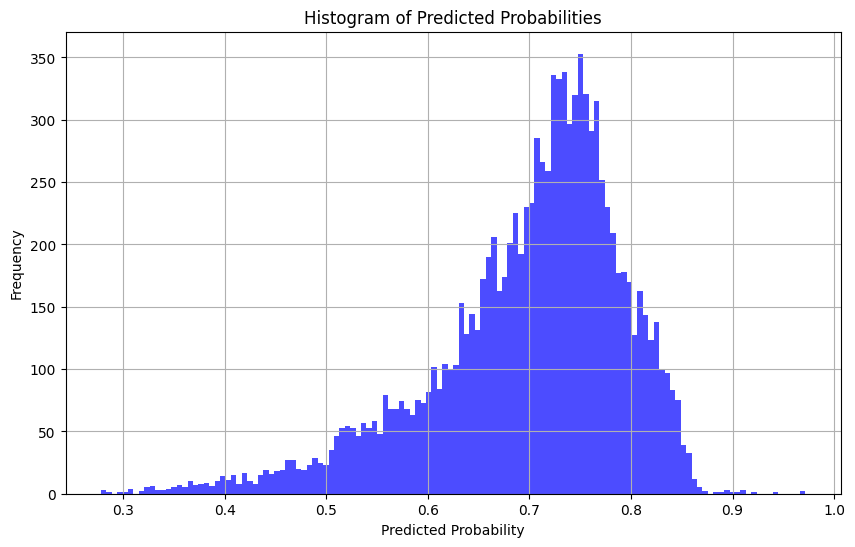

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(y_test_pred_proba1, bins=130, color='blue', alpha=0.7)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
y_test_pred1.sum()

650

In [ ]:
len(y_test_pred1)

10734

In [ ]:
submission_df.loc[dispenser1_df_test.index, "target"] = y_test_pred1

>#### **Dispenser2 학습 및 예측**

- 파라미터 :
- 임계값 : 0.834

In [ ]:
# ['Chamber Temp. Judge Value_AutoClave', 'Change in the Column', 'PROBA_WORKORDER_SUFFIX'] 칼럼 다시 categorical로 변경

train_x_resampled_df2_smote['Chamber Temp. Judge Value_AutoClave'] = train_x_resampled_df2_smote['Chamber Temp. Judge Value_AutoClave'].astype('category')
train_x_resampled_df2_smote['Change in the Column'] = train_x_resampled_df2_smote['Change in the Column'].astype('category')
train_x_resampled_df2_smote['PROBA_WORKORDER_SUFFIX'] = train_x_resampled_df2_smote['PROBA_WORKORDER_SUFFIX'].astype('category')

In [ ]:
# Validation test로 채점 => Tomek links 1번 적용 후 SMOTE 오버샘플링 후 최적의 하이퍼파라미터로 모델 학습 => dispenser2
best_param = {'border_count': 30, 'learning_rate': 0.07237071969985275, 'depth': 6, 'l2_leaf_reg': 4, 'n_estimators': 82, 'bagging_temperature': 0.7}

best_model2 = CatBoostClassifier(
    **best_param,
    loss_function='Logloss',
    eval_metric='F1',
    cat_features=['Chamber Temp. Judge Value_AutoClave', 'Change in the Column', 'PROBA_WORKORDER_SUFFIX'],
    verbose=0
)

X_dispenser2 = train_x_resampled_df2_smote
y_dispenser2 = train_y_resampled_df2_smote

# train data로 최종 모델 학습
best_model2.fit(X_dispenser2, y_dispenser2)

In [ ]:
y_test_pred_proba2 = best_model2.predict_proba(dispenser2_df_test)[:, 1]
y_test_pred2 = (y_test_pred_proba2 >= 0.88).astype(int)

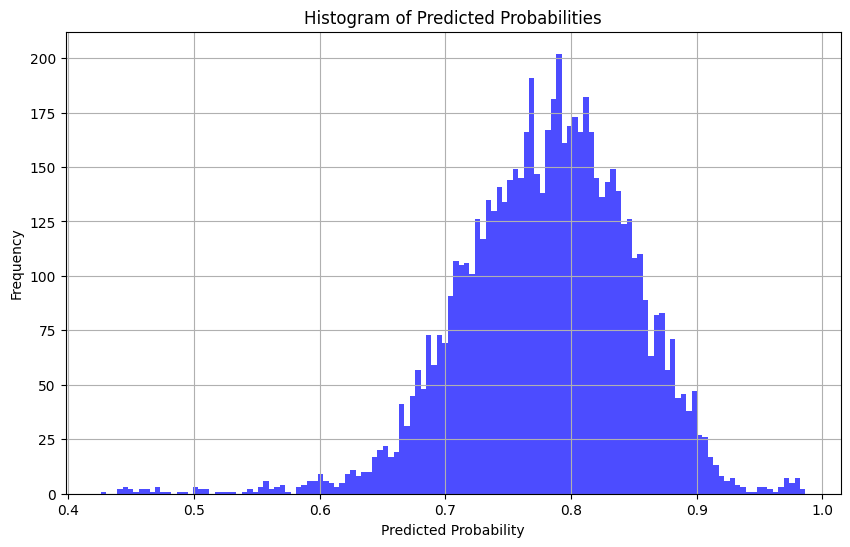

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(y_test_pred_proba2, bins=130, color='blue', alpha=0.7)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
y_test_pred2.sum()

371

In [ ]:
len(y_test_pred2)

6627

In [ ]:
submission_df.loc[dispenser2_df_test.index, "target"] = y_test_pred2

> 무조건 AbNormal인 row 수정

In [ ]:
submission_df.loc[AbNormal_row_index_list_test, "target"] = 1
submission_df['target'] = submission_df['target'].map({0: 'Normal', 1: 'AbNormal'})
submission_df['target'].value_counts()

,count
target,
Normal,16329
AbNormal,1032


In [ ]:
train_data["target"].value_counts()

,count
target,
Normal,38156
AbNormal,2350


In [ ]:
submission_df.to_csv("submission.csv", index=False)

### Analizing Prediction Result_TRAIN

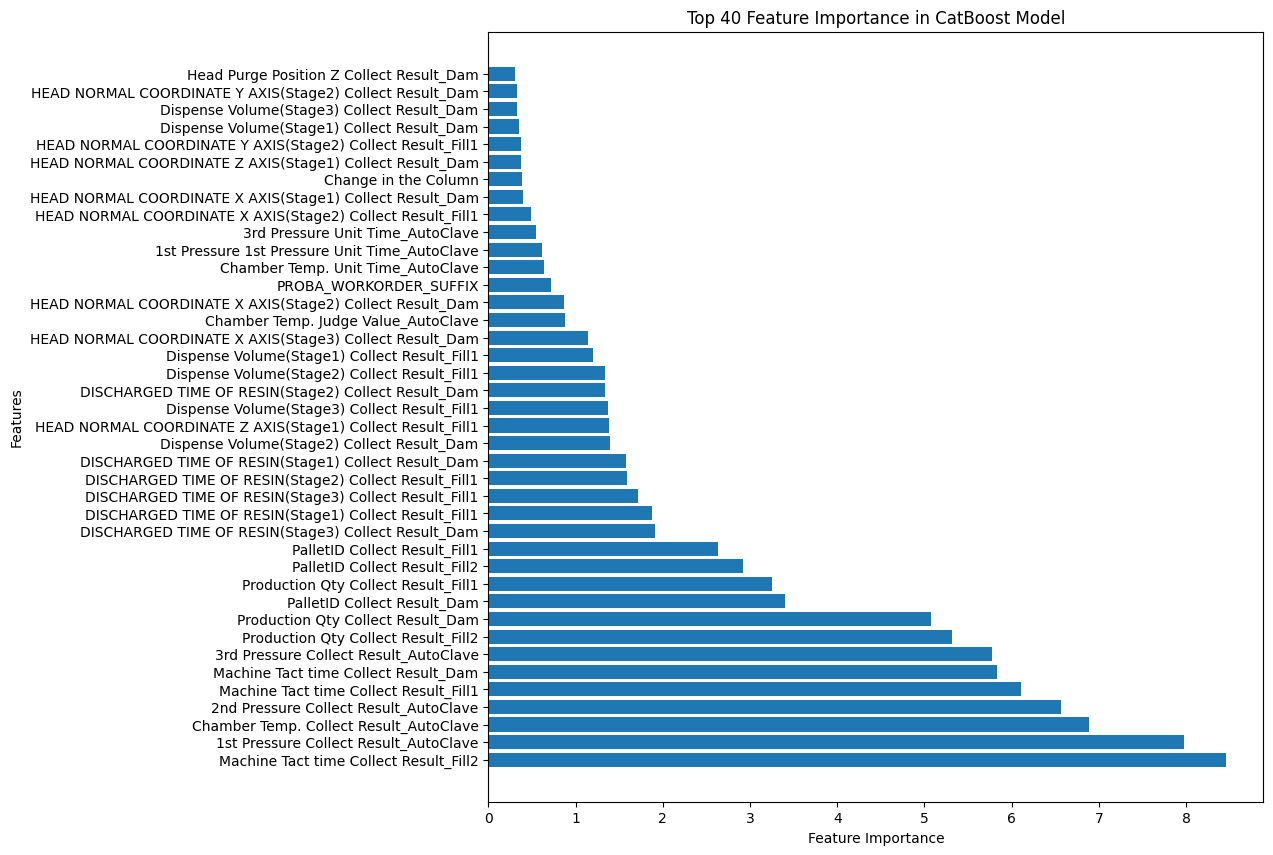

In [ ]:
# 특성 중요도 계산 및 출력
XX = dispenser1_df_train.drop(columns='target')
yy = dispenser1_df_train['target']
category_columns = dispenser1_df_train.select_dtypes(include='category').columns.tolist()
feature_importances = model1.get_feature_importance(Pool(XX, label=yy, cat_features=category_columns))

# 특성 중요도를 내림차순으로 정렬하고 상위 30개의 인덱스를 선택
sorted_idx = np.argsort(feature_importances)[::-1]  # 내림차순으로 정렬된 인덱스
top_40_idx = sorted_idx[:40]  # 상위 30개의 인덱스 선택

# 상위 30개의 특성과 중요도만 선택
top_40_features = XX.columns[top_40_idx]
top_40_importances = feature_importances[top_40_idx]

# 상위 30개 특성에 대해 시각화
plt.figure(figsize=(10, 10))
plt.barh(top_40_features, top_40_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 40 Feature Importance in CatBoost Model')
plt.show()

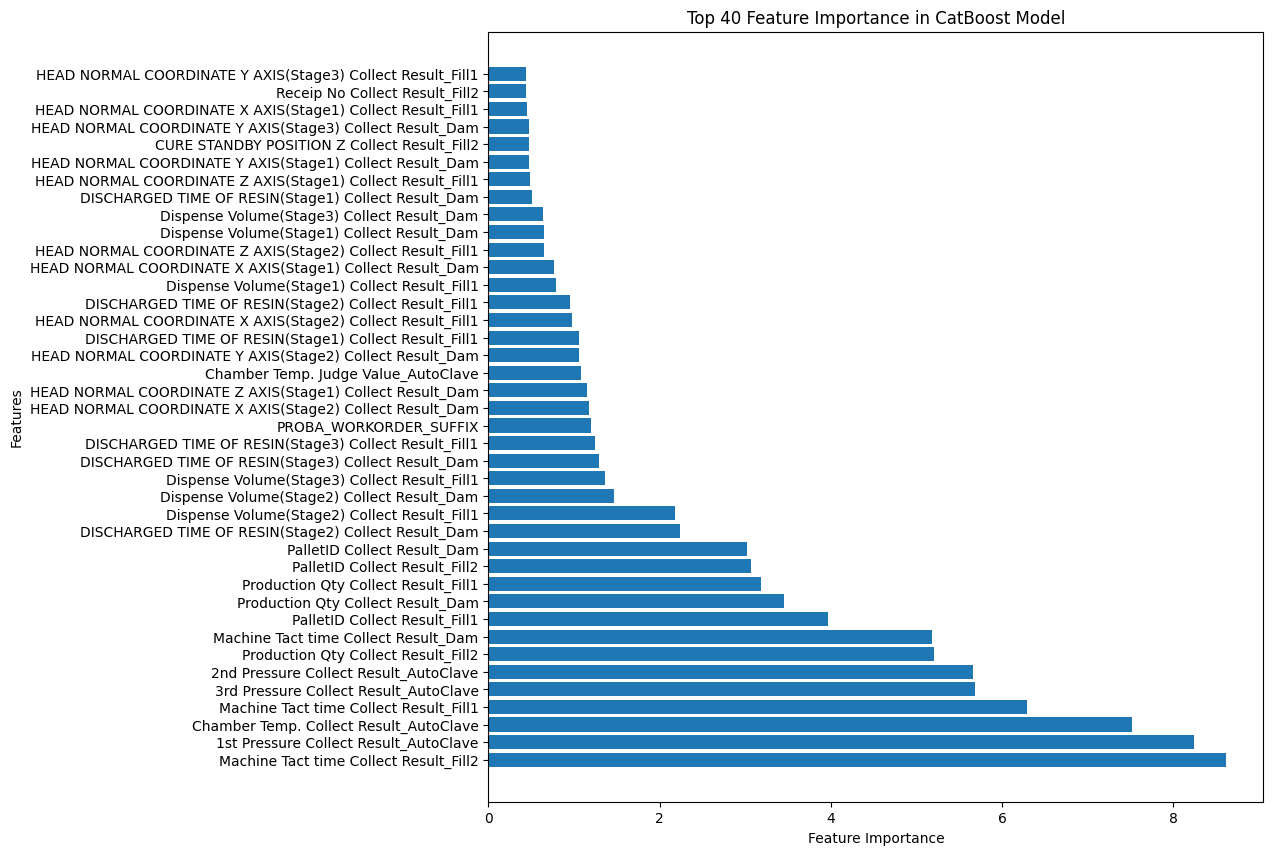

In [ ]:
# 특성 중요도 계산 및 출력
XX = dispenser2_df_train.drop(columns='target')
yy = dispenser2_df_train['target']
category_columns = dispenser2_df_train.select_dtypes(include='category').columns.tolist()
feature_importances = model2.get_feature_importance(Pool(XX, label=yy, cat_features=category_columns))

# 특성 중요도를 내림차순으로 정렬하고 상위 30개의 인덱스를 선택
sorted_idx = np.argsort(feature_importances)[::-1]  # 내림차순으로 정렬된 인덱스
top_40_idx = sorted_idx[:40]  # 상위 30개의 인덱스 선택

# 상위 30개의 특성과 중요도만 선택
top_40_features = XX.columns[top_40_idx]
top_40_importances = feature_importances[top_40_idx]

# 상위 30개 특성에 대해 시각화
plt.figure(figsize=(10, 10))
plt.barh(top_40_features, top_40_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 40 Feature Importance in CatBoost Model')
plt.show()

## 후보 방법

>- 이상 탐지 => 모델이 정상 데이터만 학습하게 하여 정상적인 패턴을 학습
- 1-class SVM
- ISOLATION FOREST
- AutoEncoder
- VAE(Variational Autoencoders)
- AAE => 적대적 오토인코더..? 는 뭐지

> over sampling
- SMOTE => 기존 데이터 포인트들 사이에 새로운 포인트를 생성
- ADASYN => 소수클래스의 밀도가 낮은 지역에 더 많은 샘플을 생성
- 정상 불량의 비율을 10:1 정도로만 낮추는 걸로...


> (AUTOENCODER) => SMOTE/ADASYN => CATBOOST

=> + 1 SVM(SMOTE 후 정상인 것만 학습 후에 이상치 탐지로 나중에 덮어씌워주자?)

> 16:1 비율 맞추는 게 f1 score는 높다.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, LeakyReLU

# 숫자형 칼럼만 추출 (target과 숫자형이 아닌 칼럼 제외)
numeric_columns = dispenser1_df_train.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop('target')  # target 칼럼 제외
X_train = dispenser1_df_train[numeric_columns]

# 데이터 정규화 (오토인코더의 입력값이므로 정규화가 필요)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
# 오토인코더 모델 생성
def get_autoencoder(input_dim, encoding_dim=18, hidden_dim_1=128, hidden_dim_2=64, dropout=0.2):
    # Input Layer
    input_layer = Input(shape=(input_dim,))

    # Encoder
    encoder = Dense(hidden_dim_1, activation='relu')(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(dropout)(encoder)
    encoder = Dense(hidden_dim_2, activation=LeakyReLU(alpha=0.2))(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dense(encoding_dim, activation='relu')(encoder)

    # Decoder
    decoder = Dense(hidden_dim_2, activation=LeakyReLU(alpha=0.2))(encoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(dropout)(decoder)
    decoder = Dense(hidden_dim_1, activation='relu')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(dropout)(decoder)
    decoder = Dense(input_dim, activation='sigmoid')(decoder)  # 원래 차원으로 복원

    # Autoencoder Model
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mse')  # 복원 손실을 MSE로 측정

    return autoencoder

input_dim = X_train_scaled.shape[1]
autoencoder = get_autoencoder(input_dim)

In [ ]:
# 오토인코더 학습
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=100, batch_size=256, shuffle=True)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.7106
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.6391
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.6620
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.6313
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6683
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7001
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6644
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.7003
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6615
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7085
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.6964
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7001
Epoch 13/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6554
Epoch 14/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6591
Epoch 15/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss:

In [ ]:
# Encoder 부분만 추출하여 차원 축소 수행
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=6).output)
X_train_reduced = encoder_model.predict(X_train_scaled)

# 원래 인덱스를 유지한 채로 데이터프레임 생성
X_train_reduced_df = pd.DataFrame(X_train_reduced, index=dispenser1_df_train.index)

783/783 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
# 숫자형이 아닌 칼럼들 추출
non_numeric_columns = dispenser1_df_train.select_dtypes(exclude=['float64', 'int64']).columns
non_numeric_df = dispenser1_df_train[non_numeric_columns]

# target 칼럼 추출
target_df = dispenser1_df_train[['target']]

# 데이터 결합
final_df = pd.concat([X_train_reduced_df, target_df, non_numeric_df], axis=1)

final_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,target,Chamber Temp. Judge Value_AutoClave,Change in the Column,PROBA_WORKORDER_SUFFIX
0,3.905121,2.583936,0.000000,2.724916,0.000000,0.000000,2.096581,2.358955,5.636594,3.125655,1.217979,6.814392,4.122285,1.102473,1.102265,4.625053,0.448237,2.930963,0,OK,NoChange,HIGH_WS
1,4.301100,0.000000,0.000000,2.104477,0.000000,4.009423,3.016196,0.000000,6.540598,0.000000,2.206195,0.000000,6.367239,2.626065,2.168343,3.206965,0.000000,3.617301,0,OK,NoChange,LOW_WS
4,0.000000,0.000000,0.757498,0.000000,4.245370,1.475567,0.017348,1.909904,4.849013,4.184512,2.813915,0.000000,6.398580,0.957266,4.565426,5.121510,0.218983,2.636763,0,NG,NoChange,LOW_WS
5,2.187523,0.000000,3.497885,1.014600,4.599149,0.000000,0.343398,2.958736,5.386968,0.629866,2.593604,0.472179,5.178242,4.687341,0.348889,9.012511,2.241976,1.231078,0,OK,NoChange,LOW_WS
6,4.541705,0.796757,0.000000,4.257698,0.000000,0.043192,1.379029,0.000000,5.717721,0.000000,0.000000,0.720360,6.882800,7.348510,0.432851,5.688736,0.099031,3.475606,0,OK,NoChange,LOW_WS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40498,0.480478,0.000000,1.433259,0.241244,5.123575,1.386038,0.000000,2.143306,3.882895,3.587907,0.934906,0.000000,7.135523,3.791259,1.827699,5.668478,0.138475,1.314731,0,OK,NoChange,LOW_WS
40499,2.799882,4.503222,0.000000,4.961355,0.000000,1.122869,4.544764,0.000000,6.839098,0.000000,3.152554,1.651259,5.270068,1.419025,1.929472,3.948946,2.074778,0.501001,0,OK,NoChange,LOW_WS
40501,5.510101,0.000000,0.000000,2.970016,0.000000,4.045639,1.183304,0.000000,3.293304,0.000000,0.604274,0.000000,3.596395,4.608316,4.927871,1.333313,0.000000,4.155586,0,OK,NoChange,LOW_WS
40503,1.785982,3.392158,0.000000,3.923363,0.000000,0.439124,3.424098,2.454873,0.542150,0.453810,3.223538,3.165023,2.467766,1.308309,3.139120,2.349118,0.008637,3.389132,0,NG,NoChange,LOW_WS


# 파생변수 만들자

### DISTANCE 파생변수

#### Dam의 Head 거리

In [ ]:
import numpy as np

# 거리 계산 함수
def calculate_distance(x1, y1, z1, x2, y2, z2):
    """
    두 좌표 (x1, y1, z1)와 (x2, y2, z2) 간의 유클리드 거리를 계산합니다.
    """
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2) * 100

# 좌표 데이터 추출
coords_columns = {
    'Head Zero': {
        'X': 'Head Zero Position X Collect Result_Dam',
        'Y': 'Head Zero Position Y Collect Result_Dam',
        'Z': 'Head Zero Position Z Collect Result_Dam'
    },
    'Head Standby': {
        'X': 'HEAD Standby Position X Collect Result_Dam',
        'Y': 'HEAD Standby Position Y Collect Result_Dam',
        'Z': 'HEAD Standby Position Z Collect Result_Dam'
    },
    'Head Normal Coordinate Stage1': {
        'X': 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
        'Y': 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
        'Z': 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'
    },
    'Head Normal Coordinate Stage2': {
        'X': 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
        'Y': 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
        'Z': 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'
    },
    'Head Normal Coordinate Stage3': {
        'X': 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
        'Y': 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
        'Z': 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'
    },
    'Head Purge Position': {
        'X': 'Head Purge Position X Collect Result_Dam',
        'Y': 'Head Purge Position Y Collect Result_Dam',
        'Z': 'Head Purge Position Z Collect Result_Dam'
    },
    'Head Clean Position': {
        'X': 'Head Clean Position X Collect Result_Dam',
        'Y': 'Head Clean Position Y Collect Result_Dam',
        'Z': 'Head Clean Position Z Collect Result_Dam'
    }
}

# 거리 계산 및 칼럼 추가
def add_distance_columns(df, coords):
    df['Distance_Zero_to_Standby'] = calculate_distance(
        df[coords['Head Zero']['X']],
        df[coords['Head Zero']['Y']],
        df[coords['Head Zero']['Z']],
        df[coords['Head Standby']['X']],
        df[coords['Head Standby']['Y']],
        df[coords['Head Standby']['Z']]
    )

    df['Distance_Standby_to_Normal_Stage1'] = calculate_distance(
        df[coords['Head Standby']['X']],
        df[coords['Head Standby']['Y']],
        df[coords['Head Standby']['Z']],
        df[coords['Head Normal Coordinate Stage1']['X']],
        df[coords['Head Normal Coordinate Stage1']['Y']],
        df[coords['Head Normal Coordinate Stage1']['Z']]
    )

    df['Distance_Normal_Stage1_to_Normal_Stage2'] = calculate_distance(
        df[coords['Head Normal Coordinate Stage1']['X']],
        df[coords['Head Normal Coordinate Stage1']['Y']],
        df[coords['Head Normal Coordinate Stage1']['Z']],
        df[coords['Head Normal Coordinate Stage2']['X']],
        df[coords['Head Normal Coordinate Stage2']['Y']],
        df[coords['Head Normal Coordinate Stage2']['Z']]
    )

    df['Distance_Normal_Stage2_to_Normal_Stage3'] = calculate_distance(
        df[coords['Head Normal Coordinate Stage2']['X']],
        df[coords['Head Normal Coordinate Stage2']['Y']],
        df[coords['Head Normal Coordinate Stage2']['Z']],
        df[coords['Head Normal Coordinate Stage3']['X']],
        df[coords['Head Normal Coordinate Stage3']['Y']],
        df[coords['Head Normal Coordinate Stage3']['Z']]
    )

    df['Distance_Normal_Stage3_to_Purge'] = calculate_distance(
        df[coords['Head Normal Coordinate Stage3']['X']],
        df[coords['Head Normal Coordinate Stage3']['Y']],
        df[coords['Head Normal Coordinate Stage3']['Z']],
        df[coords['Head Purge Position']['X']],
        df[coords['Head Purge Position']['Y']],
        df[coords['Head Purge Position']['Z']]
    )

    df['Distance_Purge_to_Clean'] = calculate_distance(
        df[coords['Head Purge Position']['X']],
        df[coords['Head Purge Position']['Y']],
        df[coords['Head Purge Position']['Z']],
        df[coords['Head Clean Position']['X']],
        df[coords['Head Clean Position']['Y']],
        df[coords['Head Clean Position']['Z']]
    )

    df['Distance_Clean_to_Zero'] = calculate_distance(
        df[coords['Head Clean Position']['X']],
        df[coords['Head Clean Position']['Y']],
        df[coords['Head Clean Position']['Z']],
        df[coords['Head Zero']['X']],
        df[coords['Head Zero']['Y']],
        df[coords['Head Zero']['Z']]
    )

# 거리 칼럼 추가
add_distance_columns(ff_dispenser2_df_train, coords_columns)

# 결과 데이터프레임 확인
ff_dispenser2_df_train[['Distance_Zero_to_Standby', 'Distance_Standby_to_Normal_Stage1',
                        'Distance_Normal_Stage1_to_Normal_Stage2', 'Distance_Normal_Stage2_to_Normal_Stage3',
                        'Distance_Normal_Stage3_to_Purge', 'Distance_Purge_to_Clean',
                        'Distance_Clean_to_Zero']].head()

,Distance_Zero_to_Standby,Distance_Standby_to_Normal_Stage1,Distance_Normal_Stage1_to_Normal_Stage2,Distance_Normal_Stage2_to_Normal_Stage3,Distance_Normal_Stage3_to_Purge,Distance_Purge_to_Clean,Distance_Clean_to_Zero
2,43185.136378,124022.568466,32307.183412,14147.119848,124955.521703,12968.104141,46599.237161
3,43183.909040,124197.883335,30310.199603,8650.699394,125054.801187,12950.000000,46395.955912
7,43185.136378,124167.128067,32307.183412,14147.119848,125039.667383,12950.000000,46396.534235
10,43185.136378,124022.568466,32307.183412,14147.119848,124955.521703,12968.104141,46599.237161
11,43185.136378,124174.762703,32307.183412,14147.119848,125016.112639,12950.000000,46396.534235


In [ ]:
# Distance_Zero_to_Standby_Dam2
ff_dispenser2_df_train['Distance_Zero_to_Standby_Dam2'] = (ff_dispenser2_df_train['Distance_Zero_to_Standby_Dam2']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Zero_to_Standby_Dam2')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Zero_to_Standby_Dam2,
43374,0.671875


In [ ]:
# Distance_Standby_to_Normal_Stage1
ff_dispenser2_df_train['Distance_Standby_to_Normal_Stage1'] = (ff_dispenser2_df_train['Distance_Standby_to_Normal_Stage1']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Standby_to_Normal_Stage1')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Standby_to_Normal_Stage1,
124004,0.307692
124384,0.671875
124906,1.000000


In [ ]:
# Distance_Normal_Stage1_to_Normal_Stage2
ff_dispenser2_df_train['Distance_Normal_Stage1_to_Normal_Stage2'] = (ff_dispenser2_df_train['Distance_Normal_Stage1_to_Normal_Stage2']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Normal_Stage1_to_Normal_Stage2')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Normal_Stage1_to_Normal_Stage2,


In [ ]:
# Distance_Normal_Stage2_to_Normal_Stage3
ff_dispenser2_df_train['Distance_Normal_Stage2_to_Normal_Stage3'] = (ff_dispenser2_df_train['Distance_Normal_Stage2_to_Normal_Stage3']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Normal_Stage2_to_Normal_Stage3')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Normal_Stage2_to_Normal_Stage3,


In [ ]:
# Distance_Normal_Stage3_to_Purge
ff_dispenser2_df_train['Distance_Normal_Stage3_to_Purge'] = (ff_dispenser2_df_train['Distance_Normal_Stage3_to_Purge']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Normal_Stage3_to_Purge')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Normal_Stage3_to_Purge,
124984,0.307692
125254,0.671875
125902,1.000000


In [ ]:
# Distance_Purge_to_Clean
ff_dispenser2_df_train['Distance_Purge_to_Clean'] = (ff_dispenser2_df_train['Distance_Purge_to_Clean']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Purge_to_Clean')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Purge_to_Clean,


In [ ]:
# Distance_Clean_to_Zero
ff_dispenser2_df_train['Distance_Clean_to_Zero'] = (ff_dispenser2_df_train['Distance_Clean_to_Zero']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Clean_to_Zero')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Clean_to_Zero,
46573,0.671875


#### fill1의 head 거리

In [ ]:
import numpy as np

# 거리 계산 함수
def calculate_distance(x1, y1, z1, x2, y2, z2):
    """
    두 좌표 (x1, y1, z1)와 (x2, y2, z2) 간의 유클리드 거리를 계산합니다.
    """
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2) * 100

# 좌표 데이터 추출
coords_columns_fill1 = {
    'Head Standby': {
        'X': 'HEAD Standby Position X Collect Result_Fill1',
        'Y': 'HEAD Standby Position Y Collect Result_Fill1',
        'Z': 'HEAD Standby Position Z Collect Result_Fill1'
    },
    'Head Normal Coordinate Stage1': {
        'X': 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
        'Y': 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
        'Z': 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'
    },
    'Head Normal Coordinate Stage2': {
        'X': 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
        'Y': 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
        'Z': 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'
    },
    'Head Normal Coordinate Stage3': {
        'X': 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
        'Y': 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
        'Z': 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'
    },
    'Head Purge Position': {
        'X': 'Head Purge Position X Collect Result_Fill1',
        'Y': 'Head Purge Position Y Collect Result_Fill1',
        'Z': 'Head Purge Position Z Collect Result_Fill1'
    },
    'Head Clean Position': {
        'X': 'Head Clean Position X Collect Result_Fill1',
        'Y': 'Head Clean Position Y Collect Result_Fill1',
        'Z': 'Head Clean Position Z Collect Result_Fill1'
    }
}

# 거리 계산 및 칼럼 추가
def add_distance_columns(df, coords):
    df['Distance_Standby_to_Normal_Stage1'] = calculate_distance(
        df[coords['Head Standby']['X']],
        df[coords['Head Standby']['Y']],
        df[coords['Head Standby']['Z']],
        df[coords['Head Normal Coordinate Stage1']['X']],
        df[coords['Head Normal Coordinate Stage1']['Y']],
        df[coords['Head Normal Coordinate Stage1']['Z']]
    )

    df['Distance_Normal_Stage1_to_Normal_Stage2'] = calculate_distance(
        df[coords['Head Normal Coordinate Stage1']['X']],
        df[coords['Head Normal Coordinate Stage1']['Y']],
        df[coords['Head Normal Coordinate Stage1']['Z']],
        df[coords['Head Normal Coordinate Stage2']['X']],
        df[coords['Head Normal Coordinate Stage2']['Y']],
        df[coords['Head Normal Coordinate Stage2']['Z']]
    )

    df['Distance_Normal_Stage2_to_Normal_Stage3'] = calculate_distance(
        df[coords['Head Normal Coordinate Stage2']['X']],
        df[coords['Head Normal Coordinate Stage2']['Y']],
        df[coords['Head Normal Coordinate Stage2']['Z']],
        df[coords['Head Normal Coordinate Stage3']['X']],
        df[coords['Head Normal Coordinate Stage3']['Y']],
        df[coords['Head Normal Coordinate Stage3']['Z']]
    )

    df['Distance_Normal_Stage3_to_Purge'] = calculate_distance(
        df[coords['Head Normal Coordinate Stage3']['X']],
        df[coords['Head Normal Coordinate Stage3']['Y']],
        df[coords['Head Normal Coordinate Stage3']['Z']],
        df[coords['Head Purge Position']['X']],
        df[coords['Head Purge Position']['Y']],
        df[coords['Head Purge Position']['Z']]
    )

    df['Distance_Purge_to_Clean'] = calculate_distance(
        df[coords['Head Purge Position']['X']],
        df[coords['Head Purge Position']['Y']],
        df[coords['Head Purge Position']['Z']],
        df[coords['Head Clean Position']['X']],
        df[coords['Head Clean Position']['Y']],
        df[coords['Head Clean Position']['Z']]
    )

# 거리 칼럼 추가
add_distance_columns(ff_dispenser2_df_train, coords_columns_fill1)

# 결과 데이터프레임 확인
ff_dispenser2_df_train[['Distance_Standby_to_Normal_Stage1', 'Distance_Normal_Stage1_to_Normal_Stage2',
                        'Distance_Normal_Stage2_to_Normal_Stage3', 'Distance_Normal_Stage3_to_Purge',
                        'Distance_Purge_to_Clean']].head()

,Distance_Standby_to_Normal_Stage1,Distance_Normal_Stage1_to_Normal_Stage2,Distance_Normal_Stage2_to_Normal_Stage3,Distance_Normal_Stage3_to_Purge,Distance_Purge_to_Clean
2,140813.072981,37980.131648,30200.059603,128530.092672,16942.549985
3,140776.149258,37890.064661,30180.014911,128347.354083,17381.369336
7,140795.152794,37960.131717,30150.059701,128528.841706,16942.549985
10,140813.072981,37980.131648,30200.059603,128530.092672,16942.549985
11,140795.152794,37910.131891,30200.059603,128528.841706,16942.549985


In [ ]:
# Distance_Standby_to_Normal_Stage1
ff_dispenser2_df_train['Distance_Standby_to_Normal_Stage1'] = (ff_dispenser2_df_train['Distance_Standby_to_Normal_Stage1']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Standby_to_Normal_Stage1')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Standby_to_Normal_Stage1,
71135,1.000000
71143,1.000000
71151,1.000000
71158,1.000000
71174,1.000000
136029,1.000000
140957,0.671875


In [ ]:
# Distance_Normal_Stage1_to_Normal_Stage2
ff_dispenser2_df_train['Distance_Normal_Stage1_to_Normal_Stage2'] = (ff_dispenser2_df_train['Distance_Normal_Stage1_to_Normal_Stage2']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Normal_Stage1_to_Normal_Stage2')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Normal_Stage1_to_Normal_Stage2,
1968,1.000000
37970,0.428571
37990,0.750000
38000,1.000000


In [ ]:
# Distance_Normal_Stage2_to_Normal_Stage3
ff_dispenser2_df_train['Distance_Normal_Stage2_to_Normal_Stage3'] = (ff_dispenser2_df_train['Distance_Normal_Stage2_to_Normal_Stage3']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Normal_Stage2_to_Normal_Stage3')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Normal_Stage2_to_Normal_Stage3,
1964,1.0
30140,1.0
30190,1.0


In [ ]:
# Distance_Normal_Stage3_to_Purge
ff_dispenser2_df_train['Distance_Normal_Stage3_to_Purge'] = (ff_dispenser2_df_train['Distance_Normal_Stage3_to_Purge']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Normal_Stage3_to_Purge')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Normal_Stage3_to_Purge,
41505,1.000000
41510,1.000000
41908,1.000000
41977,1.000000
41999,1.000000
128389,0.363636
128446,0.671875
134375,1.000000


In [ ]:
# Distance_Purge_to_Clean
ff_dispenser2_df_train['Distance_Purge_to_Clean'] = (ff_dispenser2_df_train['Distance_Purge_to_Clean']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Purge_to_Clean')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Purge_to_Clean,


#### Fill2의 Head 거리

In [ ]:
import numpy as np

# 거리 계산 함수
def calculate_distance(x1, y1, z1, x2, y2, z2):
    """
    두 좌표 (x1, y1, z1)와 (x2, y2, z2) 간의 유클리드 거리를 계산합니다.
    """
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2) * 100

# 좌표 데이터 추출 (Fill2 단계)
coords_columns_fill2 = {
    'Head Standby': {
        'X': 'HEAD Standby Position X Collect Result_Fill2',
        'Y': 'HEAD Standby Position Y Collect Result_Fill2',
        'Z': 'HEAD Standby Position Z Collect Result_Fill2'
    },
    'Head Normal Coordinate Stage1': {
        'X': 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
        'Y': 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
        'Z': 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'
    },
    'Head Normal Coordinate Stage2': {
        'X': 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
        'Y': 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
        'Z': 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'
    },
    'Head Normal Coordinate Stage3': {
        'X': 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
        'Y': 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
        'Z': 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'
    },
    'Head Purge Position': {
        'X': 'Head Purge Position X Collect Result_Fill2',
        'Y': 'Head Purge Position Y Collect Result_Fill2',
        'Z': 'Head Purge Position Z Collect Result_Fill2'
    },
    'Head Clean Position': {
        'X': 'Head Clean Position X Collect Result_Fill2',
        'Y': 'Head Clean Position Y Collect Result_Fill2',
        'Z': 'Head Clean Position Z Collect Result_Fill2'
    }
}

# 거리 계산 및 칼럼 추가
def add_distance_columns(df, coords):
    df['Distance_Standby_to_Normal_Stage1_f2'] = calculate_distance(
        df[coords['Head Standby']['X']],
        df[coords['Head Standby']['Y']],
        df[coords['Head Standby']['Z']],
        df[coords['Head Normal Coordinate Stage1']['X']],
        df[coords['Head Normal Coordinate Stage1']['Y']],
        df[coords['Head Normal Coordinate Stage1']['Z']]
    )

    df['Distance_Normal_Stage1_to_Normal_Stage2_f2'] = calculate_distance(
        df[coords['Head Normal Coordinate Stage1']['X']],
        df[coords['Head Normal Coordinate Stage1']['Y']],
        df[coords['Head Normal Coordinate Stage1']['Z']],
        df[coords['Head Normal Coordinate Stage2']['X']],
        df[coords['Head Normal Coordinate Stage2']['Y']],
        df[coords['Head Normal Coordinate Stage2']['Z']]
    )

    df['Distance_Normal_Stage2_to_Normal_Stage3_f2'] = calculate_distance(
        df[coords['Head Normal Coordinate Stage2']['X']],
        df[coords['Head Normal Coordinate Stage2']['Y']],
        df[coords['Head Normal Coordinate Stage2']['Z']],
        df[coords['Head Normal Coordinate Stage3']['X']],
        df[coords['Head Normal Coordinate Stage3']['Y']],
        df[coords['Head Normal Coordinate Stage3']['Z']]
    )

    df['Distance_Normal_Stage3_to_Purge_f2'] = calculate_distance(
        df[coords['Head Normal Coordinate Stage3']['X']],
        df[coords['Head Normal Coordinate Stage3']['Y']],
        df[coords['Head Normal Coordinate Stage3']['Z']],
        df[coords['Head Purge Position']['X']],
        df[coords['Head Purge Position']['Y']],
        df[coords['Head Purge Position']['Z']]
    )

    df['Distance_Purge_to_Clean_f2'] = calculate_distance(
        df[coords['Head Purge Position']['X']],
        df[coords['Head Purge Position']['Y']],
        df[coords['Head Purge Position']['Z']],
        df[coords['Head Clean Position']['X']],
        df[coords['Head Clean Position']['Y']],
        df[coords['Head Clean Position']['Z']]
    )

# 거리 칼럼 추가
add_distance_columns(ff_dispenser2_df_train, coords_columns_fill2)

# 결과 데이터프레임 확인
ff_dispenser2_df_train[['Distance_Standby_to_Normal_Stage1_f2', 'Distance_Normal_Stage1_to_Normal_Stage2_f2',
                        'Distance_Normal_Stage2_to_Normal_Stage3_f2', 'Distance_Normal_Stage3_to_Purge_f2',
                        'Distance_Purge_to_Clean_f2']].head()


,Distance_Standby_to_Normal_Stage1_f2,Distance_Normal_Stage1_to_Normal_Stage2_f2,Distance_Normal_Stage2_to_Normal_Stage3_f2,Distance_Normal_Stage3_to_Purge_f2,Distance_Purge_to_Clean_f2
2,129964.337031,19480.0,19420.0,134906.402982,15271.341573
3,129964.337031,19480.0,19420.0,135221.443935,15115.303503
7,129964.337031,19480.0,19420.0,135221.443935,15115.303503
10,129964.337031,19480.0,19420.0,134906.402982,15271.341573
11,129964.337031,19480.0,19420.0,135221.443935,15115.303503


In [ ]:
# Distance_Standby_to_Normal_Stage1_f2
ff_dispenser2_df_train['Distance_Standby_to_Normal_Stage1_f2'] = (ff_dispenser2_df_train['Distance_Standby_to_Normal_Stage1_f2']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Standby_to_Normal_Stage1_f2')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Standby_to_Normal_Stage1_f2,
72597,1.0


In [ ]:
# Distance_Normal_Stage1_to_Normal_Stage2_f2
ff_dispenser2_df_train['Distance_Normal_Stage1_to_Normal_Stage2_f2'] = (ff_dispenser2_df_train['Distance_Normal_Stage1_to_Normal_Stage2_f2']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Normal_Stage1_to_Normal_Stage2_f2')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Normal_Stage1_to_Normal_Stage2_f2,
37750,1.0


In [ ]:
# Distance_Normal_Stage3_to_Purge_f2
ff_dispenser2_df_train['Distance_Normal_Stage3_to_Purge_f2'] = (ff_dispenser2_df_train['Distance_Normal_Stage3_to_Purge_f2']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Normal_Stage3_to_Purge_f2')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Normal_Stage3_to_Purge_f2,
41538,1.0
42551,1.0


In [ ]:
# Distance_Purge_to_Clean_f2
ff_dispenser2_df_train['Distance_Purge_to_Clean_f2'] = (ff_dispenser2_df_train['Distance_Purge_to_Clean_f2']).astype(int)

# 그룹화 및 비율 계산
grouped = ff_dispenser2_df_train.groupby('Distance_Purge_to_Clean_f2')

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio = grouped.apply(lambda x: (x['target'] == 'AbNormal').mean())
high_abnormal_ratio = abnormal_ratio[abnormal_ratio > 0.2]
high_abnormal_ratio

,0
Distance_Purge_to_Clean_f2,


### dispenser에 따라 각각 AbNormal 비율이 높은 WorkOrder, Suffix 조합 파생변수

In [ ]:
# 그룹화 및 비율 계산
grouped1 = ff_dispenser1_df_train.groupby(['Model.Suffix_Dam', 'Workorder_Dam'])

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio1 = grouped1.apply(lambda x: (x['target'] == 'AbNormal').mean())

# AbNormal 비율이 0.2를 넘는 그룹 필터링
high_abnormal_ratio_groups1 = abnormal_ratio1[abnormal_ratio1 > 0.2]

high_abnormal_ratio_groups1

Model.Suffix_Dam  Workorder_Dam
AJX75334501       3F1XC600-1       0.242105
                  3G1XB176-1       0.240741
                  3G1XB948-2       0.212766
                  3G1XC620-1       0.250000
                  3H1X7984-2       0.289474
                  3H1XE354-1       0.800000
                  3I1XA252-1       0.285714
                  3KPXX094-0001    1.000000
                  3L1X1374-1       0.250000
                  3M1XC475-1       0.281250
                  3M1XC484-1       0.205882
                  3M1XF444-1       0.285714
                  4A1XB977-1       0.250000
                  4B1XE009-1       0.217391
                  4C1XD610-1       0.250000
                  4C1XH186-1       0.250000
                  4E1XA548-2       0.428571
AJX75334502       3K1X9887-2       0.500000
                  4A1XA434-1       0.225000
                  4A1XA458-1       0.250000
                  4A1XA713-1       0.211538
                  4A1XC288-1       1.000000
AJX75334505       4F1XA938-1       0.222222
AJX75334506       4E1X7686-1       0.250000
AJX75334507       4CPXX084-0001    1.000000
dtype: float64

In [ ]:
# 그룹화 및 비율 계산
grouped2 = ff_dispenser2_df_train.groupby(['Model.Suffix_Dam', 'Workorder_Dam'])

# 각 그룹에서 AbNormal 비율 계산
abnormal_ratio2 = grouped2.apply(lambda x: (x['target'] == 'AbNormal').mean())

# AbNormal 비율이 0.2를 넘는 그룹 필터링
high_abnormal_ratio_groups2 = abnormal_ratio2[abnormal_ratio2 > 0.2]
high_abnormal_ratio_groups2

Model.Suffix_Dam  Workorder_Dam
AJX75334501       3H1X7979-1       0.272727
                  3H1XE354-1       1.000000
                  3H1XE357-1       0.230769
                  3H1XE357-2       0.384615
                  3HPXX057-0001    0.500000
                  3HPXX124-0001    1.000000
                  3I1XA252-1       0.272727
                  3I1XA257-1       0.261905
                  3I1XB112-1       0.437500
                  3I1XB255-1       0.300000
                  3J1XE700-1       0.333333
                  3KPXX094-0001    1.000000
                  3M1XC471-1       0.250000
                  3M1XF442-1       0.233333
                  3M1XF444-1       0.303030
                  3M1XH275-1       0.333333
                  4A1XA634-2       0.250000
                  4A1XB977-1       0.304348
                  4A1XE571-1       0.500000
                  4B1XE009-1       0.440000
                  4E1XA027-2       0.320000
                  4E1XA548-2       0.875000
AJX75334502       3I1XA274-1       0.500000
                  3I1XA992-1       0.254237
                  4C1XH315-1       0.285714
AJX75334503       3HPXX066-0001    0.488636
AJX75334505       4C1XH941-1       0.206897
                  4EPM0188-1       0.266667
                  4F1XB758-2       0.260870
AJX75334506       3KPM0259-1       0.375000
dtype: float64

###  Chamber Temp, Chamber Temp unit Time 관련 파생변수
- 1000 < ff_dispenser1_df_train['Thermal Energy'] < 11000 : OK
- [ff_dispenser2_df_train['Thermal Energy'] < 11000 ] : OK

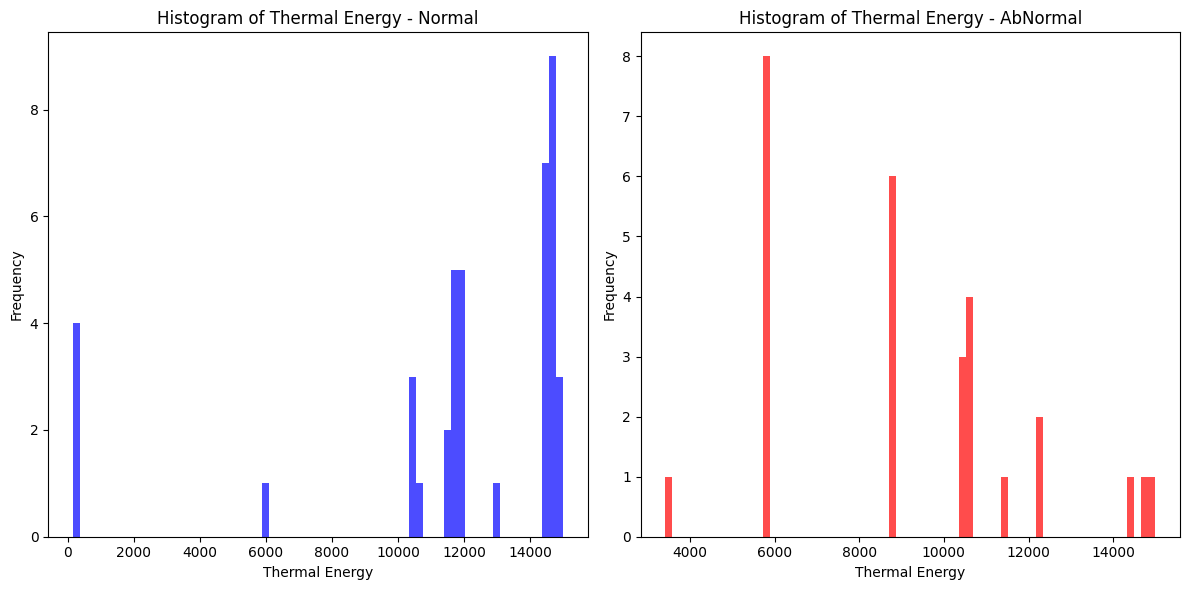

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate Thermal Energy
ff_dispenser1_df_train['Thermal Energy'] = (
    ff_dispenser1_df_train['Chamber Temp. Collect Result_AutoClave'] *
    ff_dispenser1_df_train['Chamber Temp. Unit Time_AutoClave']
)

# Filter data by target values and apply Thermal Energy threshold
normal_thermal_energy = ff_dispenser1_df_train[
    (ff_dispenser1_df_train['target'] == 'Normal') &
    (ff_dispenser1_df_train['Thermal Energy'] <= 15000)
]['Thermal Energy']

abnormal_thermal_energy = ff_dispenser1_df_train[
    (ff_dispenser1_df_train['target'] == 'AbNormal') &
    (ff_dispenser1_df_train['Thermal Energy'] <= 15000)
]['Thermal Energy']

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(normal_thermal_energy, bins=70, color='blue', alpha=0.7)
plt.title('Histogram of Thermal Energy - Normal')
plt.xlabel('Thermal Energy')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(abnormal_thermal_energy, bins=70, color='red', alpha=0.7)
plt.title('Histogram of Thermal Energy - AbNormal')
plt.xlabel('Thermal Energy')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
ff_dispenser1_df_train[(ff_dispenser1_df_train['Thermal Energy'] < 11000) & (ff_dispenser1_df_train['Thermal Energy'] > 2000 ) ]["target"].value_counts()

,count
target,
AbNormal,22
Normal,5


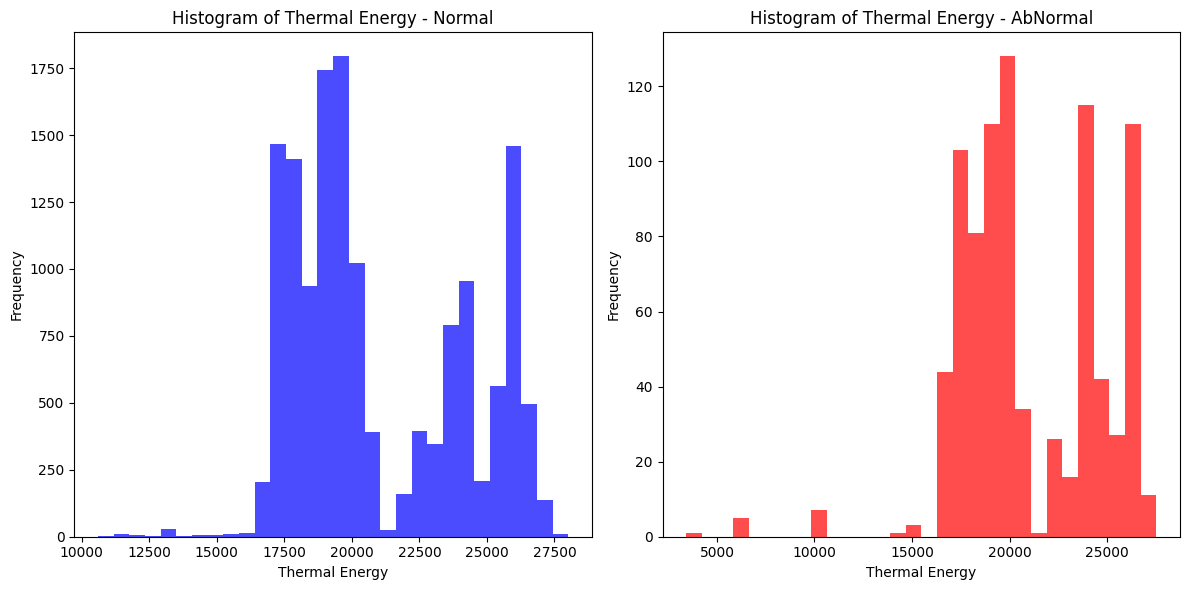

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#Thermal Energy
ff_dispenser2_df_train['Thermal Energy'] = ff_dispenser2_df_train['Chamber Temp. Collect Result_AutoClave']*ff_dispenser2_df_train['Chamber Temp. Unit Time_AutoClave']

# Filter data by target values
normal_thermal_energy = ff_dispenser2_df_train[ff_dispenser2_df_train['target'] == 'Normal']['Thermal Energy']
abnormal_thermal_energy = ff_dispenser2_df_train[ff_dispenser2_df_train['target'] == 'AbNormal']['Thermal Energy']

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(normal_thermal_energy, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Thermal Energy - Normal')
plt.xlabel('Thermal Energy')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(abnormal_thermal_energy, bins=30, color='red', alpha=0.7)
plt.title('Histogram of Thermal Energy - AbNormal')
plt.xlabel('Thermal Energy')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
ff_dispenser2_df_train[ff_dispenser2_df_train['Thermal Energy'] < 11000 ]["target"].value_counts()

,count
target,
AbNormal,13
Normal,2
